## Method

First end-point (logic explained in code) the data and perform pre-emphasis. Then extract 40 MFCC features from the data. Retain the first 13 and also calculate 13 delta and 13 delta_delta of these features, thus, giving 39 dimensional features. Then train an HMM model for each word. For evaluation, find the HMM score for each word by passing through each of the HMM models. The model giving maximum score corresponds to the predicted word.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa
from IPython.display import Audio
from hmmlearn import hmm

In [2]:
%matplotlib inline

In [3]:
'''
! mkdir Data
! unzip Commands\ Dataset/train/'*.zip' -d Data/train
! unzip Commands\ Dataset/test_clean.zip -d Data/test
! unzip Commands\ Dataset/test_noisy.zip -d Data/test
! unzip Commands\ Dataset/_background_noise_.zip -d Data/noise
'''
! ls

20D070059_3.html  20D070059_3.zip   Data
20D070059_3.ipynb Commands Dataset


In [4]:
X_train, y_train = [], []    # to store training audio and labels
word2num = {}    # to map word to a number
num = 0

for word in os.listdir('Data/train'):
    word2num[word] = num
    num += 1
    for utterance in os.listdir(f'Data/train/{word}'):
        audio, fs = librosa.load(f'Data/train/{word}/{utterance}', sr=16e3)
        X_train.append(audio)
        y_train.append(word2num[word])

In [5]:
X_test_clean, y_test_clean = [], []    # to store clean testing audio and labels

for word in os.listdir('Data/test/test_clean'):
    for utterance in os.listdir(f'Data/test/test_clean/{word}'):
        audio, fs = librosa.load(f'Data/test/test_clean/{word}/{utterance}', sr=16e3)
        X_test_clean.append(audio)
        y_test_clean.append(word2num[word])

In [6]:
X_test_noisy, y_test_noisy = [], []    # to store noisy testing audio and labels

for word in os.listdir('Data/test/test_noisy'):
    for utterance in os.listdir(f'Data/test/test_noisy/{word}'):
        audio, fs = librosa.load(f'Data/test/test_noisy/{word}/{utterance}', sr=16e3)
        X_test_noisy.append(audio)
        y_test_noisy.append(word2num[word])

In [7]:
len(X_train), len(X_test_clean), len(X_test_noisy)

(23682, 2567, 2567)

## Data Preprocessing

Using hamming window of length 20ms (0.02*16000 = 320 samples)

In [8]:
window = np.hamming(320)

In [9]:
def energy(signal):    # returns energy of the signal
    E = 0
    for i in range(len(signal)):
        E += signal[i]**2
    return E


def sign(x):    # sign function
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1


def zcr(signal):      # returns zero crossing rate of signal
    ZCR = 0
    for i in range(1, len(signal)):
        ZCR += 0.5 * abs(sign(signal[i]) - sign(signal[i-1]))
    ZCR /= len(signal)
    return ZCR

### End-pointing

For end-pointing, we need to remove silence from beginning and ending of the audio signal. For this, we need to approximately detect the point after which utterance starts and the point after which utterance ends. Short time energy can be used here to detect silence. A threshold of 0.01 times the total signal energy divided by number of frames can be used to detect silence.

Note that the signal amplitude should be subtracted by its mean before calculating short time energy or average signal energy per frame for better detection.

Thus, we choose the utterance start point as the sample after which STE is greater than threshold for 5 hops (including the start point) consecutively, and utterance end point as the sample for the reversed audio signal after which STE is greater than threshold for 5 hops (including the end point) consecutively.

In [11]:
hop = 160    # hop of 20 samples

In [13]:
def endpointing(audio, window, threshold):    # removes silence from the beginning and end of audio signal
    
    ste_list, stzcr_list = [], []
    
    for i in range(0, len(audio) - len(window) + 1, hop):
        ste = energy(audio[i : i + len(window)] * window)    # short time energy
        ste_list.append(ste)
        
    start = 0
    end = len(ste_list) - 1
    
    for i in range(4, len(ste_list)):
        sat = 0
        for j in range(5):
            if ste_list[i-j] > threshold:
                sat += 1
            else:
                break
        if sat == 5:
            start = i - 4
            break

    for i in range(len(ste_list)-5, -1, -1):
        sat = 0
        for j in range(5):
            if ste_list[i+j] > threshold:
                sat += 1
            else:
                break
        if sat == 5:
            end = i + 4
            break
    
    return start, end

Trying out end-pointing on some examples

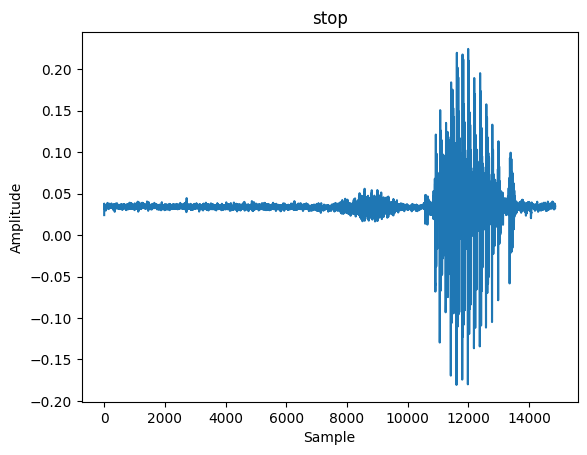

In [14]:
plt.plot(range(len(X_train[11000])), X_train[11000])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(list(word2num.keys())[list(word2num.values()).index(y_train[11000])])
plt.show()

In [15]:
Audio(X_train[11000], rate=16e3)

In [21]:
threshold = 0.01 * energy(X_train[11000] - X_train[11000].mean()) / ((len(X_train[11000]) - len(window)) // hop + 1)    # total energy of signal (mean adjusted to 0) divided by number of frames
print(threshold)
endpointing(X_train[11000] - X_train[11000].mean(), window, threshold)

0.001022682460545597


(48, 87)

In [22]:
Audio(X_train[11000][48*hop:83*hop], rate=16e3)

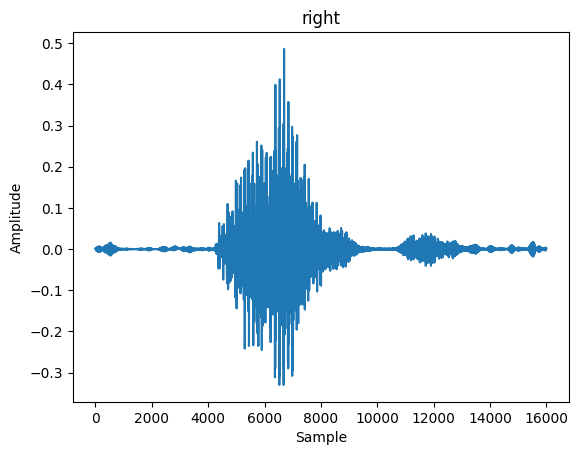

In [23]:
plt.plot(range(len(X_train[1000])), X_train[1000])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title(list(word2num.keys())[list(word2num.values()).index(y_train[1000])])
plt.show()

In [24]:
Audio(X_train[1000], rate=16e3)

In [25]:
threshold = 0.01 * energy(X_train[1000] - X_train[1000].mean()) / ((len(X_train[1000]) - len(window)) // hop + 1)    # total energy of signal (mean adjusted to 0) divided by number of frames
print(threshold)
endpointing(X_train[1000] - X_train[1000].mean(), window, threshold)

0.002653815488815609


(26, 79)

In [26]:
Audio(X_train[1000][26*hop:79*hop], rate=16e3)

In [27]:
# Carrying out end-pointing for all signals
for i in range(len(X_train)):
    threshold = 0.01 * energy(X_train[i] - X_train[i].mean()) / ((len(X_train[i]) - len(window)) // hop + 1)    # total energy of signal (mean adjusted to 0) divided by number of frames
    start, end = endpointing(X_train[i] - X_train[i].mean(), window, threshold)
    X_train[i] = X_train[i][start*hop:(end+1)*hop]

In [28]:
# Carrying out end-pointing for all signals
for i in range(len(X_test_clean)):
    threshold = 0.01 * energy(X_test_clean[i] - X_test_clean[i].mean()) / ((len(X_test_clean[i]) - len(window)) // hop + 1)    # total energy of signal (mean adjusted to 0) divided by number of frames
    start, end = endpointing(X_test_clean[i] - X_test_clean[i].mean(), window, threshold)
    X_test_clean[i] = X_test_clean[i][start*hop:(end+1)*hop]

for i in range(len(X_test_noisy)):
    threshold = 0.01 * energy(X_test_noisy[i] - X_test_noisy[i].mean()) / ((len(X_test_noisy[i]) - len(window)) // hop + 1)    # total energy of signal (mean adjusted to 0) divided by number of frames
    start, end = endpointing(X_test_noisy[i] - X_test_noisy[i].mean(), window, threshold)
    X_test_noisy[i] = X_test_noisy[i][start*hop:(end+1)*hop]

### Pre-emphasis

Pre-emphasis of a signal $x[n]$ can be carried out as follows.
$$Y(z) = (1-\alpha z^{-1})X(z),$$
where $\alpha \in [0,1].$

Equivalently,
$$y[n] = x[n] - \alpha x[n-1]$$

In [29]:
# Assume x[-1] = 0 (needed for y[0])

alpha = 0.95

for i in range(len(X_train)):
    temp = X_train[i].copy()
    for j in range(1, len(X_train[i])):    # X_train[i][0] will remain the same because sample at index -1 is assumed to be 0
        X_train[i][j] = temp[j] - alpha*temp[j-1]

In [30]:
for i in range(len(X_test_clean)):
    temp = X_test_clean[i].copy()
    for j in range(1, len(X_test_clean[i])):    # X_test_clean[i][0] will remain the same because sample at index -1 is assumed to be 0
        X_test_clean[i][j] = temp[j] - alpha*temp[j-1]

for i in range(len(X_test_noisy)):
    temp = X_test_noisy[i].copy()
    for j in range(1, len(X_test_noisy[i])):    # X_test_noisy[i][0] will remain the same because sample at index -1 is assumed to be 0
        X_test_noisy[i][j] = temp[j] - alpha*temp[j-1]

## Feature Extraction

### MFCC Feature extraction

In [35]:
train_features = []

for i in range(len(X_train)):

    if len(X_train[i]) < 2048:    # since n_fft = 1024 in next step
        continue

    c = librosa.feature.mfcc(y=X_train[i], sr=16e3, n_mfcc=40, n_fft=1024, hop_length=hop, win_length=len(window), window='hamming', center=False, n_mels=40)    # shape = (40, num_frames)
    c = c[:13]
    
    delta = np.zeros((13, c.shape[1]))
    delta[:, 0] = 0.5 * c[:, 1]
    for j in range(1, c.shape[1]-1):
        delta[:, j] = 0.5 * (c[:, j+1] - c[:, j-1])
    delta[:, c.shape[1]-1] = -0.5 * c[:, c.shape[1]-2]
    
    deltadelta = np.zeros((13, c.shape[1]))
    deltadelta[:, 0] = 0.5 * delta[:, 1]
    for j in range(1, c.shape[1] - 1):
        deltadelta[:, j] = 0.5 * (delta[:, j+1] - delta[:, j-1])
    deltadelta[:, c.shape[1]-1] = -0.5 * delta[:, c.shape[1]-2]

    train_features.append(np.concatenate([c, delta, deltadelta], axis=0))

In [36]:
test_clean_features = []

for i in range(len(X_test_clean)):
    
    if len(X_test_clean[i]) < 2048:    # since n_fft = 1024 in next step
        continue

    c = librosa.feature.mfcc(y=X_test_clean[i], sr=16e3, n_mfcc=40, n_fft=1024, hop_length=hop, win_length=len(window), window='hamming', center=False, n_mels=40)    # shape = (40, num_frames)
    c = c[:13]
    
    delta = np.zeros((13, c.shape[1]))
    delta[:, 0] = 0.5 * c[:, 1]
    for j in range(1, c.shape[1]-1):
        delta[:, j] = 0.5 * (c[:, j+1] - c[:, j-1])
    delta[:, c.shape[1]-1] = -0.5 * c[:, c.shape[1]-2]
    
    deltadelta = np.zeros((13, c.shape[1]))
    deltadelta[:, 0] = 0.5 * delta[:, 1]
    for j in range(1, c.shape[1] - 1):
        deltadelta[:, j] = 0.5 * (delta[:, j+1] - delta[:, j-1])
    deltadelta[:, c.shape[1]-1] = -0.5 * delta[:, c.shape[1]-2]

    test_clean_features.append(np.concatenate([c, delta, deltadelta], axis=0))


test_noisy_features = []

for i in range(len(X_test_noisy)):

    if len(X_test_noisy[i]) < 2048:    # since n_fft = 1024 in next step
        continue

    c = librosa.feature.mfcc(y=X_test_noisy[i], sr=16e3, n_mfcc=40, n_fft=1024, hop_length=hop, win_length=len(window), window='hamming', center=False, n_mels=40)    # shape = (40, num_frames)
    c = c[:13]
    
    delta = np.zeros((13, c.shape[1]))
    delta[:, 0] = 0.5 * c[:, 1]
    for j in range(1, c.shape[1]-1):
        delta[:, j] = 0.5 * (c[:, j+1] - c[:, j-1])
    delta[:, c.shape[1]-1] = -0.5 * c[:, c.shape[1]-2]
    
    deltadelta = np.zeros((13, c.shape[1]))
    deltadelta[:, 0] = 0.5 * delta[:, 1]
    for j in range(1, c.shape[1] - 1):
        deltadelta[:, j] = 0.5 * (delta[:, j+1] - delta[:, j-1])
    deltadelta[:, c.shape[1]-1] = -0.5 * delta[:, c.shape[1]-2]

    test_noisy_features.append(np.concatenate([c, delta, deltadelta], axis=0))

In [37]:
train_word_features = []    # to store the word_features (see line 4) of different words
train_word_features_frame_len = []    # to store the frame lengths of each utterance

word_features = []    # to store the concatenation of features of a single word uttered by different speakers
word_features.append(train_features[0])
train_word_features_frame_len.append([])    
train_word_features_frame_len[-1].append(train_features[0].shape[1])

for i in range(1, len(train_features)):
    if y_train[i] == y_train[i-1]:
        word_features.append(train_features[i])
        train_word_features_frame_len[-1].append(train_features[i].shape[1])
    else:
        train_word_features.append(np.concatenate(word_features, axis=1))
        word_features = []
        word_features.append(train_features[i])
        train_word_features_frame_len.append([])
        train_word_features_frame_len[-1].append(train_features[i].shape[1])
train_word_features.append(np.concatenate(word_features, axis=1))    # required for the last word because else block won't be executed

In [38]:
test_clean_word_features = []    # to store the word_features (see line 4) of different words
test_clean_word_features_frame_len = []    # to store the frame lengths of each utterance

word_features = []    # to store the concatenation of features of a single word uttered by different speakers
word_features.append(test_clean_features[0])
test_clean_word_features_frame_len.append([])    
test_clean_word_features_frame_len[-1].append(test_clean_features[0].shape[1])

for i in range(1, len(test_clean_features)):
    if y_test_clean[i] == y_test_clean[i-1]:
        word_features.append(test_clean_features[i])
        test_clean_word_features_frame_len[-1].append(test_clean_features[i].shape[1])
    else:
        test_clean_word_features.append(np.concatenate(word_features, axis=1))
        word_features = []
        word_features.append(test_clean_features[i])
        test_clean_word_features_frame_len.append([])
        test_clean_word_features_frame_len[-1].append(test_clean_features[i].shape[1])
test_clean_word_features.append(np.concatenate(word_features, axis=1))    # required for the last word because else block won't be executed


test_noisy_word_features = []    # to store the word_features (see line 4) of different words
test_noisy_word_features_frame_len = []    # to store the frame lengths of each utterance

word_features = []    # to store the concatenation of features of a single word uttered by different speakers
word_features.append(test_noisy_features[0])
test_noisy_word_features_frame_len.append([])    
test_noisy_word_features_frame_len[-1].append(test_noisy_features[0].shape[1])

for i in range(1, len(test_noisy_features)):
    if y_test_noisy[i] == y_test_noisy[i-1]:
        word_features.append(test_noisy_features[i])
        test_noisy_word_features_frame_len[-1].append(test_noisy_features[i].shape[1])
    else:
        test_noisy_word_features.append(np.concatenate(word_features, axis=1))
        word_features = []
        word_features.append(test_noisy_features[i])
        test_noisy_word_features_frame_len.append([])
        test_noisy_word_features_frame_len[-1].append(test_noisy_features[i].shape[1])
test_noisy_word_features.append(np.concatenate(word_features, axis=1))    # required for the last word because else block won't be executed

## Model

### Gaussian Mixture Model - Hidden Markov Model (GMM-HMM)

Reference: https://github.com/MaharshiYeluri01/SpeechRecognition/blob/master/Speech_recognition_5.ipynb

In [44]:
class HMMTrainer(object):

    def __init__(self, n_states=4, cov_type='diag', n_iter=100):
        self.n_states = n_states
        self.cov_type = cov_type
        self.n_iter = n_iter
        self.model = hmm.GaussianHMM(n_components=n_states, covariance_type=cov_type, n_iter=n_iter)

    def train(self, x, framelengths):    # x.shape = (39, N) [N = number of frames, 39 = feature dimensions]
        self.model.fit(x.transpose(1, 0), framelengths)

    def get_score(self, x):    # x.shape = (39, N) [N = number of frames, 39 = feature dimensions]; computes log likelihood of x
        return self.model.score(x.transpose(1, 0))

### Training

In [45]:
hmm_models = []    # one hmm model for each word

for i in range(len(train_word_features)):
    print(i)
    hmm_trainer = HMMTrainer()
    hmm_trainer.train(train_word_features[i], train_word_features_frame_len[i])
    hmm_models.append((hmm_trainer, i))
    hmm_trainer = None

0
1
2
3
4
5
6
7
8
9


## Evaluation

### Accuracy

In [46]:
train_correct = 0
train_predictions = []
for i in range(len(train_features)):
    train_scores = []
    for hmm_model, label in hmm_models:
        score = hmm_model.get_score(train_features[i])
        train_scores.append(score)
    train_predictions.append(np.array(train_scores).argmax())
    if np.array(train_scores).argmax() == y_train[i]:
        train_correct += 1
print('Training accuracy:', 100*train_correct/len(train_features))

Training accuracy: 68.38275730783874


In [47]:
test_clean_correct = 0
test_clean_predictions = []
for i in range(len(test_clean_features)):
    test_clean_scores = []
    for hmm_model, label in hmm_models:
        score = hmm_model.get_score(test_clean_features[i])
        test_clean_scores.append(score)
    test_clean_predictions.append(np.array(test_clean_scores).argmax())
    if np.array(test_clean_scores).argmax() == y_test_clean[i]:
        test_clean_correct += 1
print('Testing (clean) accuracy:', 100*test_clean_correct/len(test_clean_features))

test_noisy_correct = 0
test_noisy_predictions = []
for i in range(len(test_noisy_features)):
    test_noisy_scores = []
    for hmm_model, label in hmm_models:
        score = hmm_model.get_score(test_noisy_features[i])
        test_noisy_scores.append(score)
    test_noisy_predictions.append(np.array(test_noisy_scores).argmax())
    if np.array(test_noisy_scores).argmax() == y_test_noisy[i]:
        test_noisy_correct += 1
print('Testing (noisy) accuracy:', 100*test_noisy_correct/len(test_noisy_features))

Testing (clean) accuracy: 69.46505271378368
Testing (noisy) accuracy: 48.731954740538434


### Confusion Matrix

In [48]:
num2word = {}
for key, value in word2num.items():
    num2word[value] = key
num2word

{0: 'right',
 1: 'go',
 2: 'no',
 3: 'left',
 4: 'stop',
 5: 'up',
 6: 'down',
 7: 'yes',
 8: 'on',
 9: 'off'}

In [49]:
train_confusion = np.zeros((10, 10), dtype=int)
for i in range(len(train_predictions)):
    for j in range(len(train_predictions)):
        train_confusion[y_train[i], train_predictions[j]] += 1

In [50]:
test_clean_confusion = np.zeros((10, 10), dtype=int)
for i in range(len(test_clean_predictions)):
    for j in range(len(test_clean_predictions)):
        test_clean_confusion[y_test_clean[i], test_clean_predictions[j]] += 1

test_noisy_confusion = np.zeros((10, 10), dtype=int)
for i in range(len(test_noisy_predictions)):
    for j in range(len(test_noisy_predictions)):
        test_noisy_confusion[y_test_noisy[i], test_noisy_predictions[j]] += 1

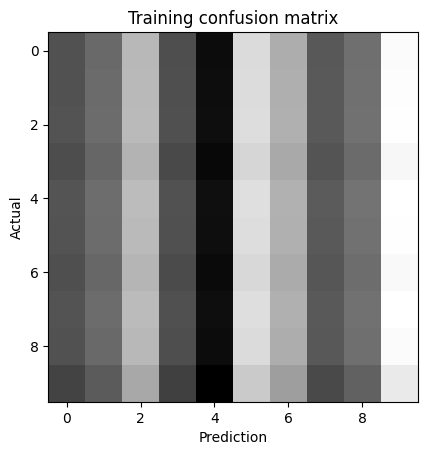

In [51]:
plt.imshow(train_confusion, cmap='gray')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Training confusion matrix')
plt.show()

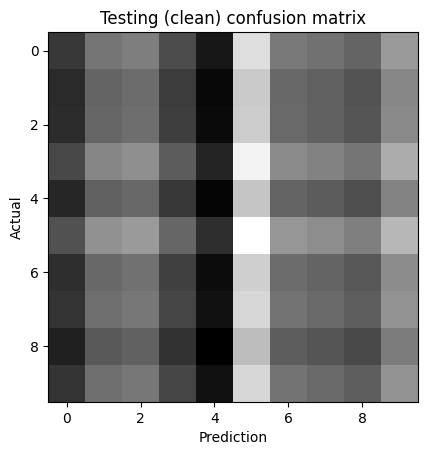

In [52]:
plt.imshow(test_clean_confusion, cmap='gray')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Testing (clean) confusion matrix')
plt.show()

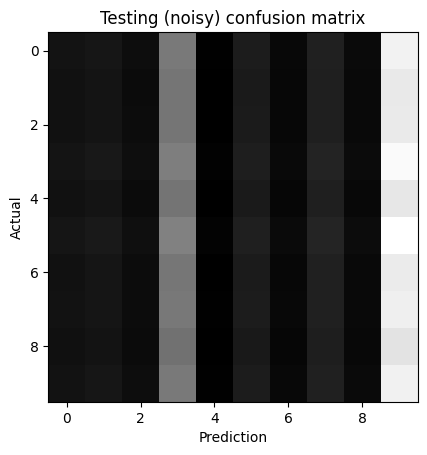

In [53]:
plt.imshow(test_noisy_confusion, cmap='gray')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Testing (noisy) confusion matrix')
plt.show()

It seems that the model isn't trained properly. Ideally the non-principal diagonal of the confusion matrix should be brighter than all the other squares.

Probably, changing the number of hops checked during end-pointing might improve the model. Changing n_components of HMM might also work. Increasing n_iter did not help.